In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set();

In [4]:
from sklearn.preprocessing import *

In [5]:
import glob,os,re

In [6]:
path = '/Users/eulerr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'
files = os.listdir(path)
files

['air_store_info.csv',
 'date_info.csv',
 'store_id_relation.csv',
 'hpg_reserve.csv',
 'air_reserve.csv',
 'air_visit_data.csv',
 'sample_submission.csv',
 'hpg_store_info.csv']

# References 

The content of this notebook was based on the solution proposed in this [post](https://www.kaggle.com/the1owl/surprise-me/code) on Kaggle.

# Data Cleaning 

In [13]:
data = {
    'tra': pd.read_csv(path+'air_visit_data.csv'),
    'as': pd.read_csv(path+'air_store_info.csv'),
    'hs': pd.read_csv(path+'hpg_store_info.csv'),
    'ar': pd.read_csv(path+'air_reserve.csv'),
    'hr': pd.read_csv(path+'hpg_reserve.csv'),
    'id': pd.read_csv(path+'store_id_relation.csv'),
    'tes': pd.read_csv(path+'sample_submission.csv'),
    'hol': pd.read_csv(path+'date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [14]:
data['id'].head(2)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809


In [15]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [16]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[[
        'reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})

In [17]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [18]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': 
    [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [19]:
stores.shape,data['tra'].shape

((5747, 2), (252108, 6))

In [20]:
stores.air_store_id.nunique(),len(unique_stores)

(821, 821)

Here they group all the data per day **dow** means : day of week. We could also try reduce the grain, to shift of day for example. 

In [21]:
tmp = data['tra'].groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

In [22]:
tmp.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1,22.457143,19.0,47,35
1,air_00a91d42b08b08d9,1,1,24.350000,24.5,43,40


In [23]:
stores.shape,data['as'].shape

((5747, 7), (829, 5))

In [24]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
stores.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [25]:
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [26]:
stores.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599


In [27]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [28]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id','dow'])

In [29]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]
train = train.fillna(-1)  # This step is important ! 
test = test.fillna(-1)    

In [30]:
train.shape

(252108, 19)

In [31]:
train.head(2)

,air_store_id,visit_date,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0


In [33]:
#train.air_store_id.value_counts()

In [38]:
datashow = train[(train['air_store_id'] == 'air_ba937bf13d40fb24')|
                 (train['air_store_id'] == 'air_ba937bf13d40fb24')][['air_store_id',
                                                                     'visit_date',
                                                                     'mean_visitors']].copy()

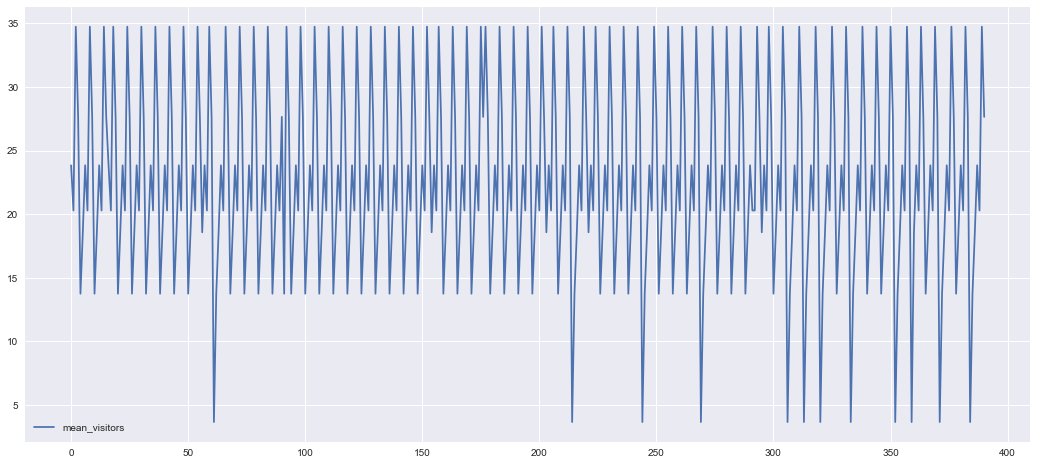

In [39]:
datashow.plot(figsize=(18,8))

In [40]:
#Transforming target

logp1 = datashow.mean_visitors.map(pd.np.log1p)
diff = np.log(datashow.mean_visitors).diff()[1:]


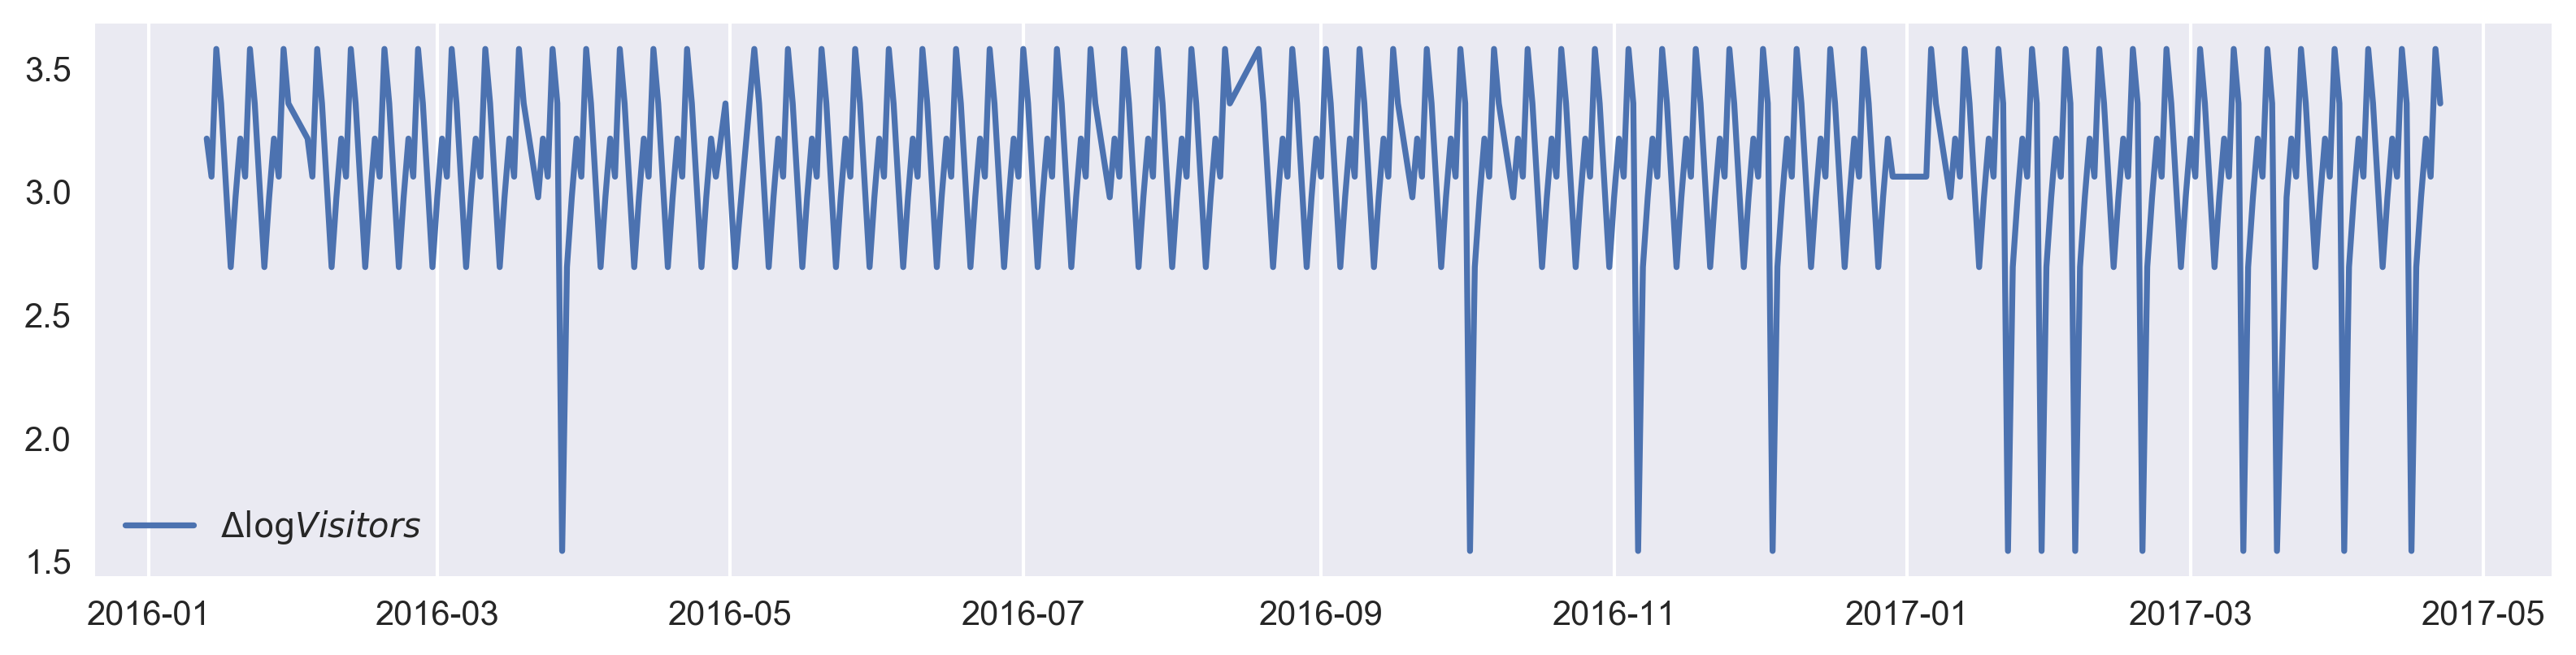

In [41]:
# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(datashow.visit_date, logp1, label=r'$\Delta \log Visitors$')
ax.legend(loc='lower left')
ax.yaxis.grid();

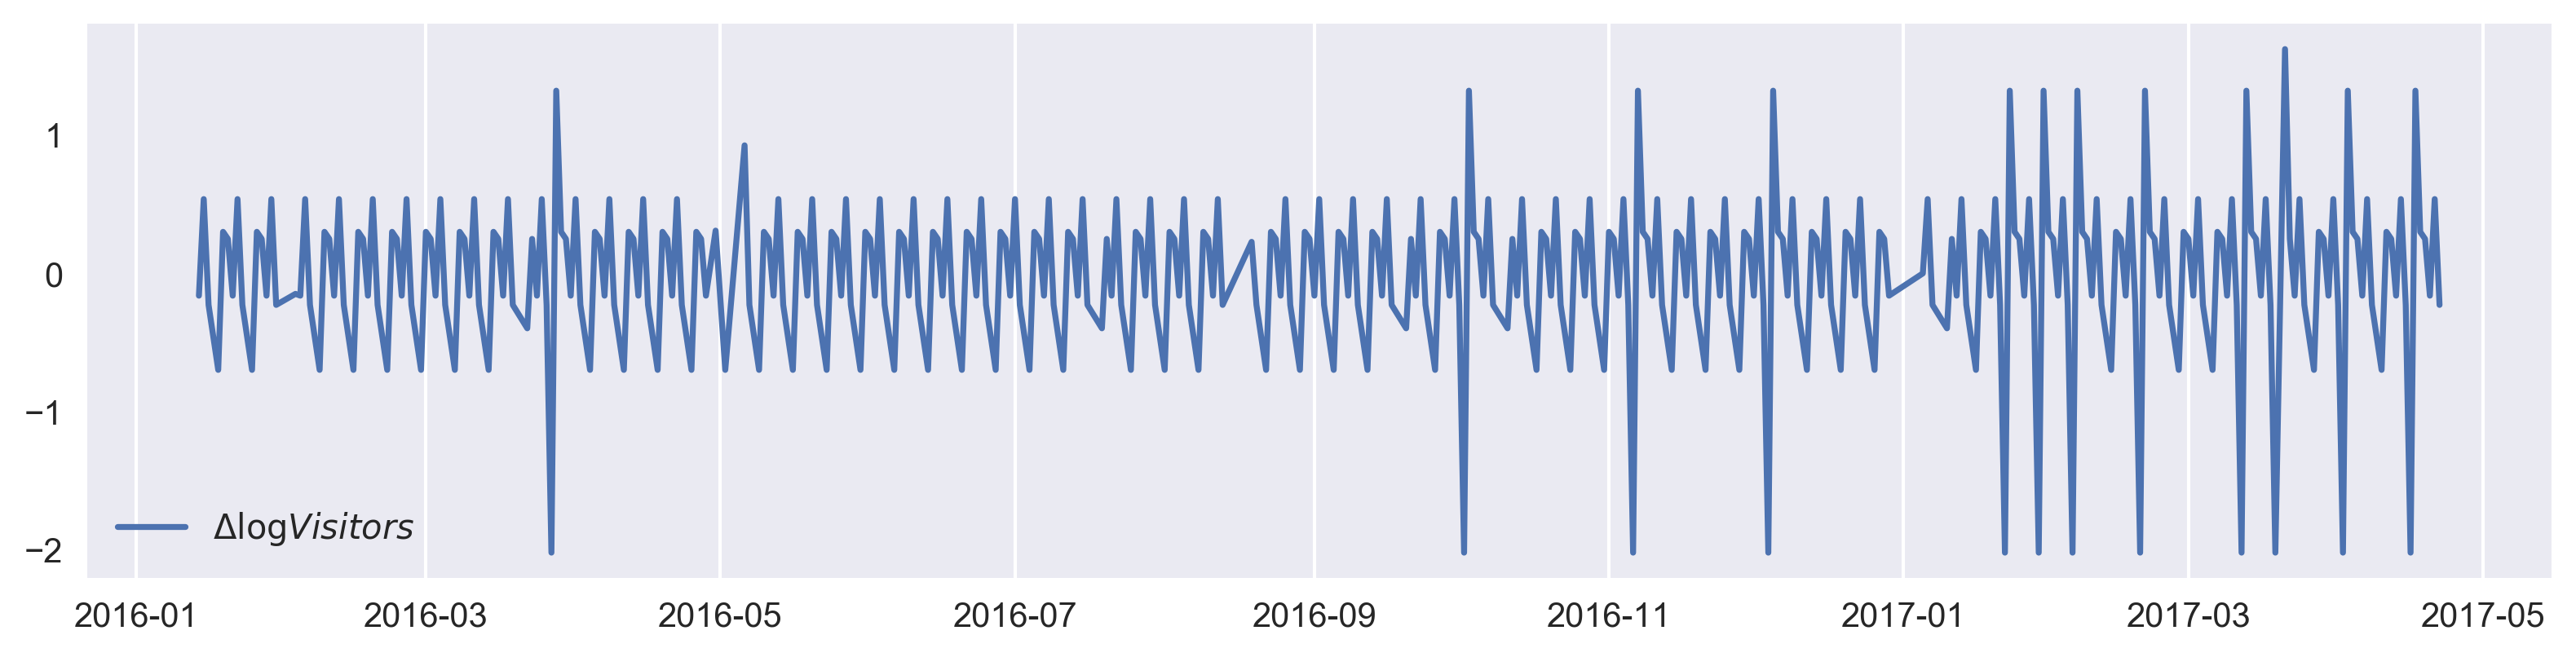

In [42]:
# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(datashow.visit_date[1:], diff, label=r'$\Delta \log Visitors$')
ax.legend(loc='lower left')
ax.yaxis.grid();

# Weighted Average

This was another solution proposed by [zeemeen](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st)

In [13]:
#"START HKLEE FEATURE"
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob( path +'*.csv')}
for k, v in dfs.items(): locals()[k] = v

In [25]:
for k,v in  dfs.items():
    print(k)

air_store_info
date_info
store_id_relation
hpg_reserve
air_reserve
air_visit_data
sample_submission
hpg_store_info


In [40]:
date_info.head(5)

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
3,2016-01-04,Monday,0,2.772345e-11
4,2016-01-05,Tuesday,0,8.460525e-11


In [32]:
wkend_holidays = date_info.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
wkend_holidays.value_counts()

False    508
True       9
dtype: int64

In [33]:
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

# Weight : New feature..

In [65]:
date_info['weight'].describe()


count    5.170000e+02
mean     1.676353e-01
std      2.527871e-01
min      2.707368e-14
25%      1.005227e-03
50%      3.155340e-02
75%      2.380707e-01
max      1.000000e+00
Name: weight, dtype: float64

In [39]:
air_visit_data.head(5)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [50]:
visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)

In [51]:
visit_data.head(5)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weight
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1.005227e-08
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1.456087e-08
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,2.055908e-08
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,2.838881e-08
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,5.115756e-08


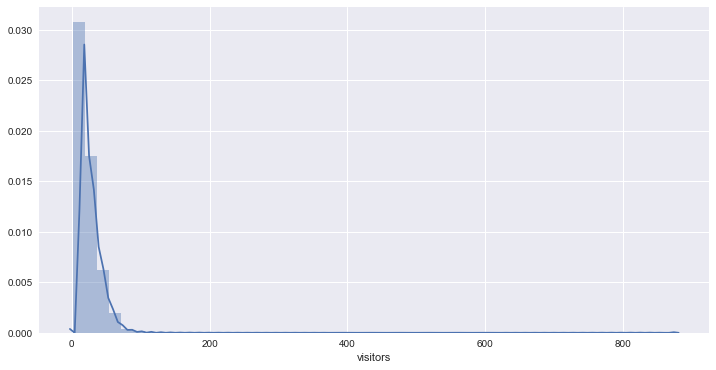

In [52]:
plt.figure(figsize=(12,6))
sns.distplot(visit_data['visitors'])
#plt.xscale('log')
#plt.title("Shares Distribution")
plt.show()


In [53]:
visit_data['visitors'].describe()

count    252108.000000
mean         20.973761
std          16.757007
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

In [54]:
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)
visit_data['visitors'].describe()

count    252108.000000
mean          2.802788
std           0.807726
min           0.693147
25%           2.302585
50%           2.890372
75%           3.401197
max           6.777647
Name: visitors, dtype: float64

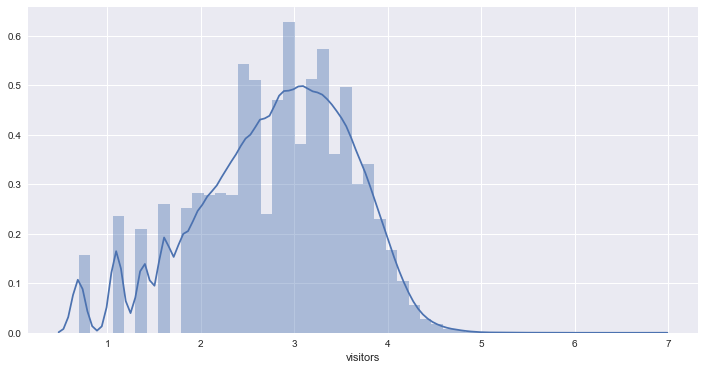

In [55]:
plt.figure(figsize=(12,6))
sns.distplot(visit_data['visitors'])
#plt.xscale('log')
#plt.title("Shares Distribution")
plt.show()



In [58]:
visit_data.head(5)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weight
0,air_ba937bf13d40fb24,2016-01-13,3.258097,Wednesday,0,1.005227e-08
1,air_ba937bf13d40fb24,2016-01-14,3.496508,Thursday,0,1.456087e-08
2,air_ba937bf13d40fb24,2016-01-15,3.401197,Friday,0,2.055908e-08
3,air_ba937bf13d40fb24,2016-01-16,3.135494,Saturday,0,2.838881e-08
4,air_ba937bf13d40fb24,2016-01-18,1.945910,Monday,0,5.115756e-08


In [67]:
visit_data.shape

(252108, 6)

In [60]:
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) 

In [66]:
visitors.shape

(9103, 4)

In [61]:
visitors.head(5)

,air_store_id,day_of_week,holiday_flg,visitors
0,air_00a91d42b08b08d9,Friday,0,3.583535
1,air_00a91d42b08b08d9,Monday,0,3.203625
2,air_00a91d42b08b08d9,Monday,1,3.091042
3,air_00a91d42b08b08d9,Saturday,0,2.524065
4,air_00a91d42b08b08d9,Sunday,0,1.098612


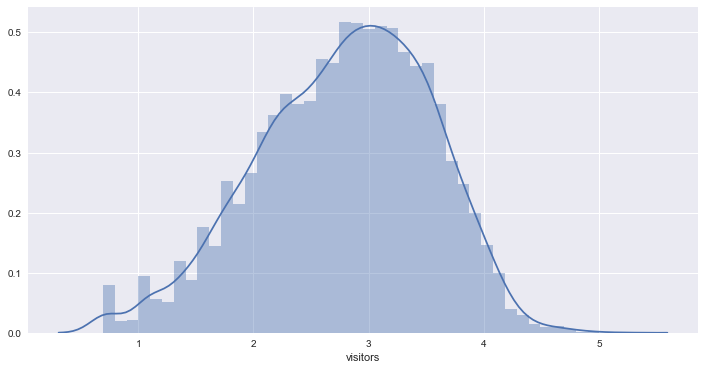

In [63]:
plt.figure(figsize=(12,6))
sns.distplot(visitors['visitors'])
#plt.xscale('log')
#plt.title("Shares Distribution")
plt.show()